# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip -q install phik
!pip install scikit-learn==1.1.3 -q
!pip install lightgbm
!pip install xgboost
!pip install catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import phik
import lightgbm as lgb


from random import randint
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import time
import numpy as np

RANDOM_STATE = 100
TEST_SIZE = 0.25


## Подготовка данных

In [3]:
try:
    data= pd.read_csv(r'C:\Users\dinos\Downloads\autos.csv', sep=',')
    
except:
    data= pd.read_csv('/datasets/autos.csv', sep=',')

pd.set_option('display.max_columns', None)

In [4]:
def info(df):
    display(df.head(5))
    display(df.info()) 
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print(f'Количество пропусков: {df.isna().sum()}')

In [5]:
info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Количество дубликатов: 4
Количество пропусков: DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


* В заголовках необходимо поменять стиль (например, NumberOfPictures - убрать заглавные и тп)
* Имеются 4 дубликата
* В VehicleType, Gearbox, Model, FuelType, Repaired Имеються пропуски

### Предобработка данных

In [6]:
#Удаление дупликатов
data.drop_duplicates(inplace=True)

In [7]:
#Смена стиля заголовков
data.columns = data.columns.str.replace(r"([A-Z])", r" \1", regex=True) \
                           .str.lower() \
                           .str.replace(' ', '_') \
                           .str.lstrip('_')
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Оброботка целевого признака

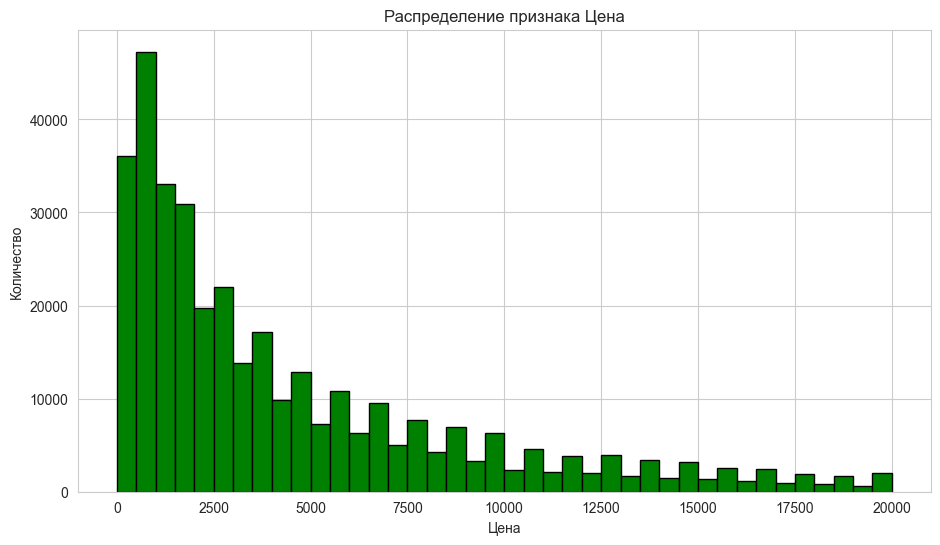

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


In [8]:
sns.set_style('whitegrid')
plt.figure(figsize=(11, 6))
plt.hist(data.price, color = 'green', edgecolor = 'black', bins = 40)
plt.title(f"Распределение признака {'Цена'}")
plt.ylabel("Количество")
plt.xlabel('Цена')
plt.show()
print(data.price.describe())

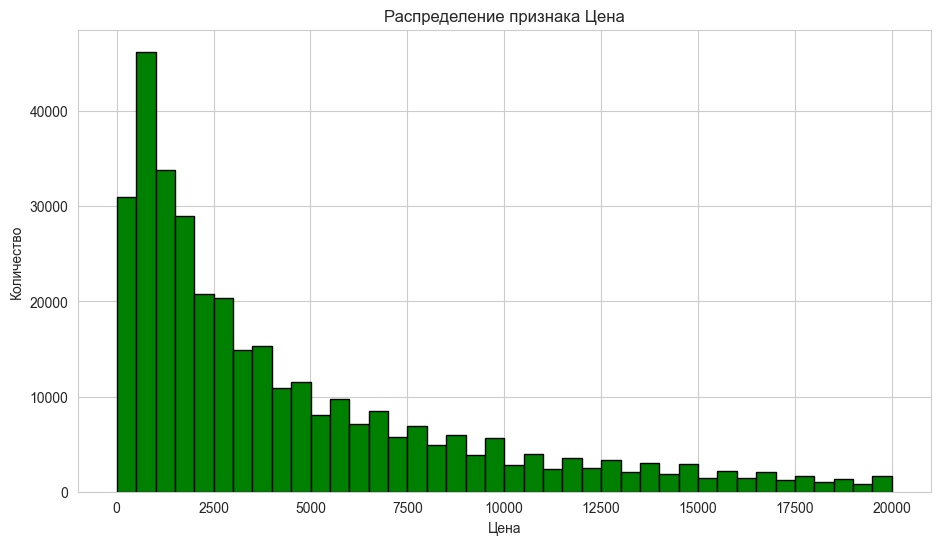

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


In [9]:
#удаляю 0 из целевого признака (цена не может быть 0)
data = data.query('price > 0')

sns.set_style('whitegrid')
plt.figure(figsize=(11, 6))
plt.hist(data.price, color = 'green', edgecolor = 'black', bins = 40)
plt.title(f"Распределение признака {'Цена'}")
plt.ylabel("Количество")
plt.xlabel('Цена')
plt.show()
print(data.price.describe())

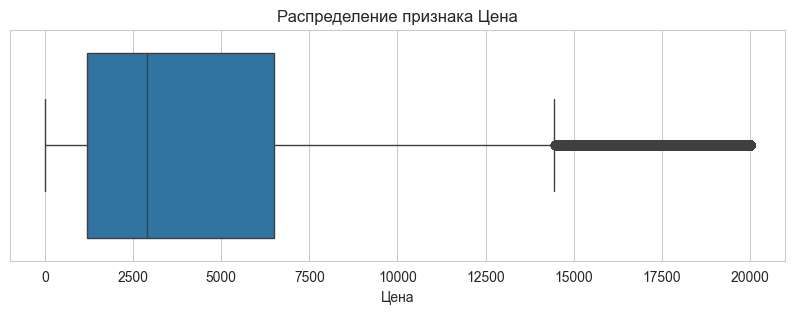

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [10]:
plt.figure(figsize=(10,3))
sns.boxplot(data=data.price, orient='h')
plt.title(f"Распределение признака {'Цена'}")
plt.xlabel('Цена')
plt.show()
data.price.quantile([.05, 0.95])

Видим выбросы после 14800, отбросим данные до квантили 0.05 и после 0.95

In [11]:
data = data.query('350 <= price <= 14800')

In [12]:
data

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


#### Категориальные признаки

In [13]:
columns = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

for column in columns:
    print(data[column].unique())
    print('\n')

[nan 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']


[1993 2004 2001 2008 1995 2014 1998 2005 1910 2007 2009 2002 2018 1997
 1990 2017 1981 2003 2016 1991 1984 2006 1999 2012 2010 2000 1992 2013
 1994 1996 1989 2011 1985 1982 1976 1973 2015 1969 1971 1987 1983 1988
 1980 1970 1986 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961
 1966 1975 1963 1964 1958 1967 3200 1960 1941 9999 8888 1500 4100 1962
 1929 1957 2066 1949 1940 2019 1937 1951 1800 1959 1954 1234 5300 9000
 2900 6000 1953 5911 1000 1400 5000 4000 1952 8500 1950 3700 3800 4800
 1942 7000 1956 1935 1936 1923 2290 1930 1001 9450 1944 2500 1938 1934
 1943 1928 5555 1600 1111 1932 1039 3000 2800 1931 1948 4500 1602 7800
 7100 1300 8200 1946]


['manual' 'auto' nan]


['golf' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat' 'ka'
 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva' 'arosa' 'other' 'c4'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'one'
 'fortwo' '1er' 'b_klasse'

* заполню пропуски в vehicle_type на unknown
* Странные даты лет, исключу лишнее
* заполню пропуски в gearbox на unknown
* заполню пропуски в model на unknown
* заполню пропуски в fuel_type на unknown
* заполню пропуски в repaired на unknown

vehicle_type

In [14]:
data['vehicle_type'] = data['vehicle_type'].fillna(value='unknown')
data['vehicle_type'].value_counts()

vehicle_type
sedan          82545
small          71292
wagon          58780
unknown        28664
bus            26480
convertible    17528
coupe          13328
suv             9485
other           2790
Name: count, dtype: int64

registration_year

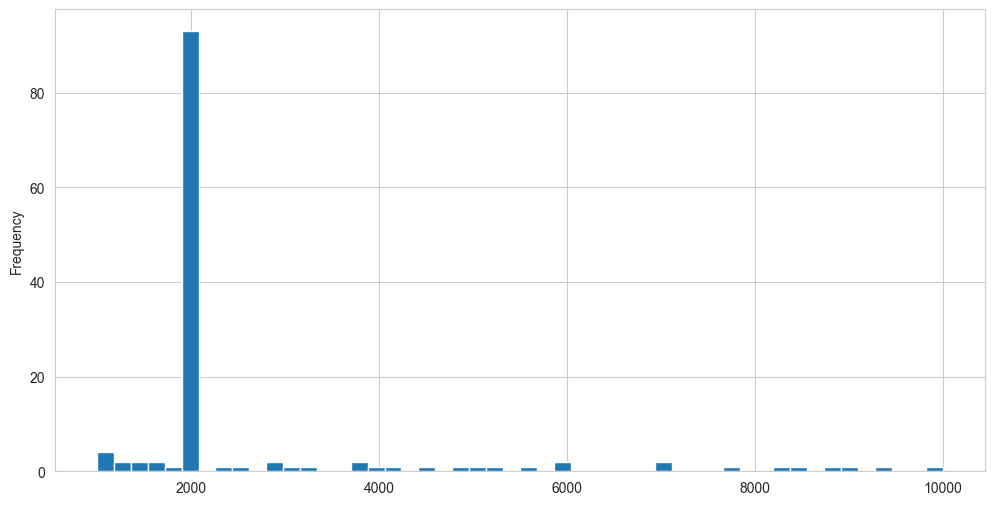

In [15]:
pd.Series(list(data.registration_year.unique())).sort_values(ascending=False).plot(kind='hist', 
                                                                                   figsize=(12,6), 
                                                                                   grid=True, 
                                                                                   bins=50)
plt.show()

Я исключу данные об автомобилях, зарегистрированных после 2024 года и до 1980 года (другие машины могут иметь год выпуска раньше года регистрации, но это уже редкость, и их стоимость формируется иначе).

In [16]:
data['date_crawled'].sort_values().tail(1)

90713    2016-04-07 14:36:58
Name: date_crawled, dtype: object

In [17]:
data = data[(data['registration_year'] >= 1980) & (data['registration_year'] <= 2016)]

gearbox

In [18]:
data['gearbox'].isna().sum()

12115

In [19]:
data['gearbox']=data['gearbox'].fillna('unknow');

C:\Users\dinos\AppData\Local\Temp\ipykernel_36856\4136663534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gearbox']=data['gearbox'].fillna('unknow');


model

In [20]:
data['model'].isna().sum()

12759

In [21]:
data['model']=data['model'].fillna('unknow');

C:\Users\dinos\AppData\Local\Temp\ipykernel_36856\3043361496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model']=data['model'].fillna('unknow');


repaired

In [22]:
data['repaired'].isna().sum()

51074

In [23]:
data['repaired']=data['repaired'].fillna('unknow');

C:\Users\dinos\AppData\Local\Temp\ipykernel_36856\1173106547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['repaired']=data['repaired'].fillna('unknow');


fuel_type

In [24]:
data['fuel_type'].value_counts()

fuel_type
petrol      184962
gasoline     85265
lpg           4832
cng            513
hybrid         169
other          106
electric        76
Name: count, dtype: int64

In [25]:
data['fuel_type'].isna().sum()

19316

In [26]:
data['fuel_type']=data['fuel_type'].fillna('unknow');

C:\Users\dinos\AppData\Local\Temp\ipykernel_36856\147754875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fuel_type']=data['fuel_type'].fillna('unknow');


#### Численные признаки

In [27]:
num_col=['power', 'kilometer', 'registration_month', 'number_of_pictures']
titles_num = ['Мощность', 'Километраж', 'Месяц регистрации', 'Кол-во картинок']

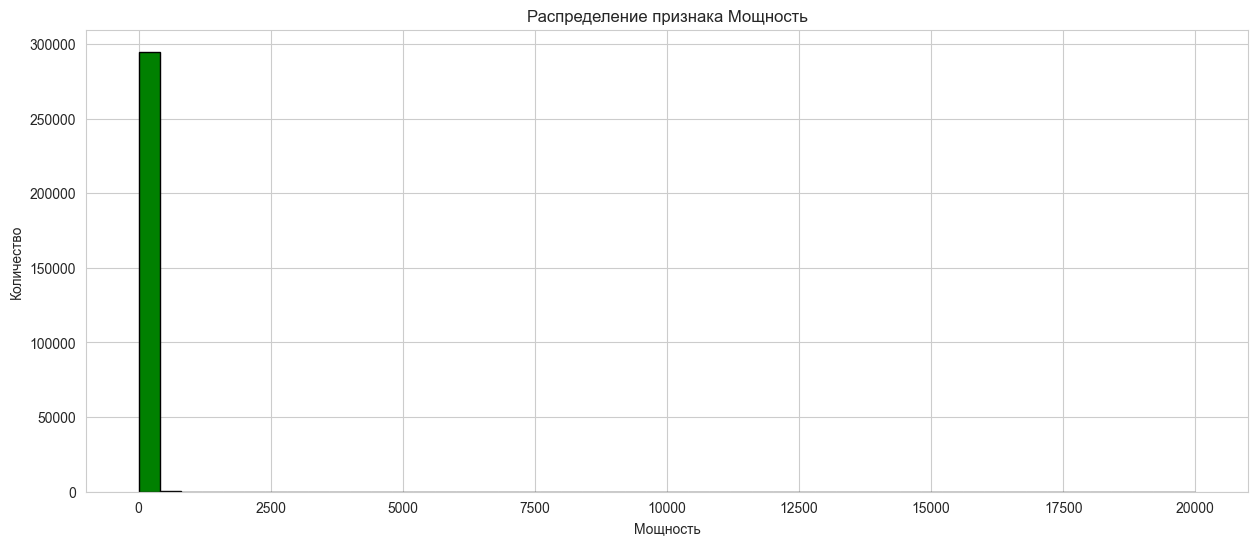

count    295239.000000
mean        111.109339
std         184.742237
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64


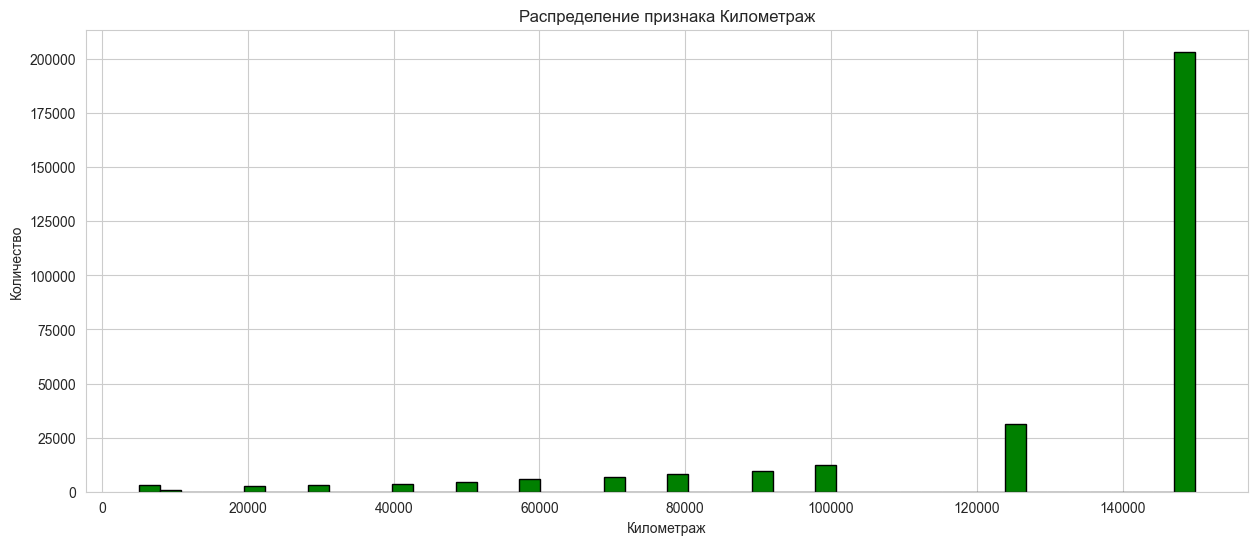

count    295239.000000
mean     130492.787200
std       35168.663232
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


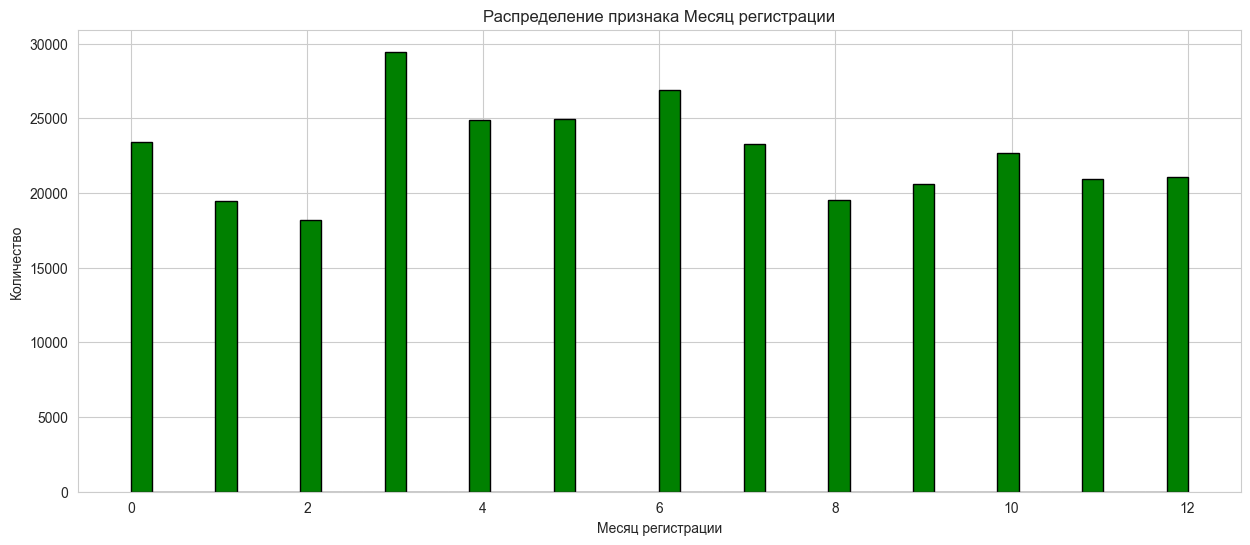

count    295239.000000
mean          5.904532
std           3.651624
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


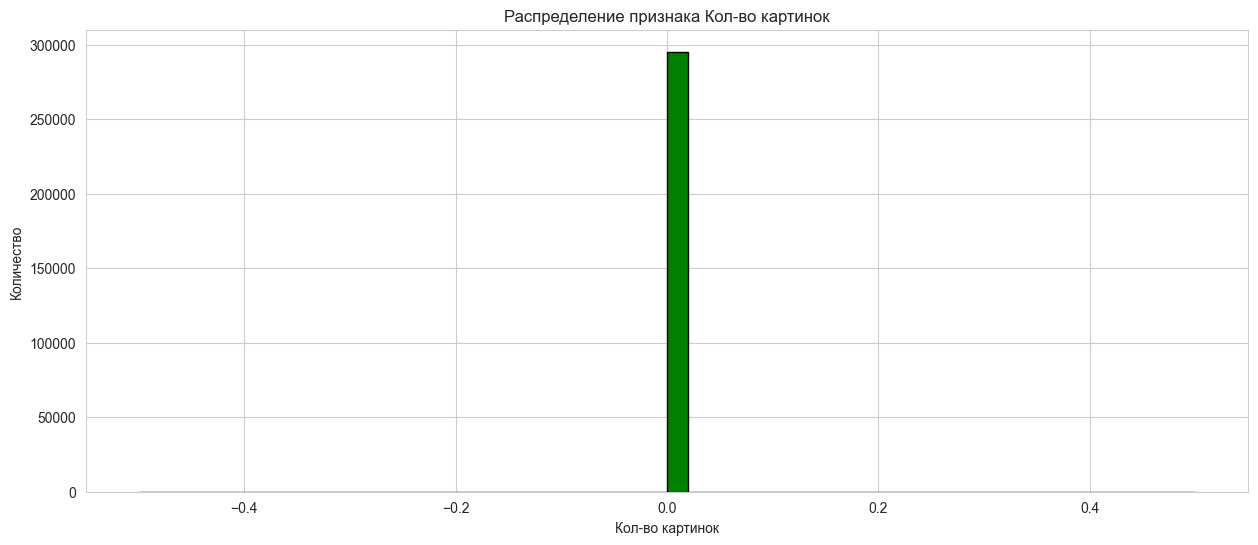

count    295239.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64


In [28]:
for i in range(len(num_col)):
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 6))
    plt.hist(data[num_col[i]], color = 'green', edgecolor = 'black', bins = 50)
    plt.title(f"Распределение признака {titles_num[i]}")
    plt.ylabel("Количество")
    plt.xlabel(titles_num[i])
    plt.show()
    print(data[num_col[i]].describe())

Имеется 0 месяц в registration_month

0 мог появиться по разным причинам. Например, раньше 0 месяц мог обозначать январь, но впоследствии его заменили на 1, а старые данные с 0 остались неизменными. Либо месяц регистрации просто не указывался, и вместо nan использовали 0. В любом случае данных с 0 слишком много, чтобы менять их на 1 месяц или вовсе удалять их, поэтому оставим как есть.

Невозможно, чтобы мощность двигателя была равна 0 или 20000 л.с., так как таких автомобилей не существует. По этой причине я удалю эти данные. Согласно информации, найденной в интернете, самая мощные машины в мире на данный момент имеют около 2000 л.с., поэтому я удалю все значения, превышающие этот показатель. Также выяснил, что у старых автомобилей минимальная мощность — 9 л.с.

In [29]:
data = data.query('9 <= power <= 2000')

Удалим столбцы date_crawled и number_of_pictures, так как они не влияют на целевой признак

In [30]:
data = data.drop(['date_crawled', 'number_of_pictures'], axis=1)

### Корреляция данных

In [31]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

In [32]:
int_data = data.drop(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired','date_created','last_seen'], axis=1)
int_data.corr()

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.551982,0.376691,-0.338565,0.064449,0.050932
registration_year,0.551982,1.000000,0.060957,-0.328418,0.033824,0.022191
power,0.376691,0.060957,1.000000,0.133557,0.023929,0.034472
kilometer,-0.338565,-0.328418,0.133557,1.000000,-0.013060,-0.001408
registration_month,0.064449,0.033824,0.023929,-0.013060,1.000000,0.000364
postal_code,0.050932,0.022191,0.034472,-0.001408,0.000364,1.000000


Столбцы date_created, last_seen, postal_code не связаны с целевым признаком, поэтому удлим их

In [33]:
data= data.drop(['date_created', 'last_seen', 'postal_code'], axis=1)

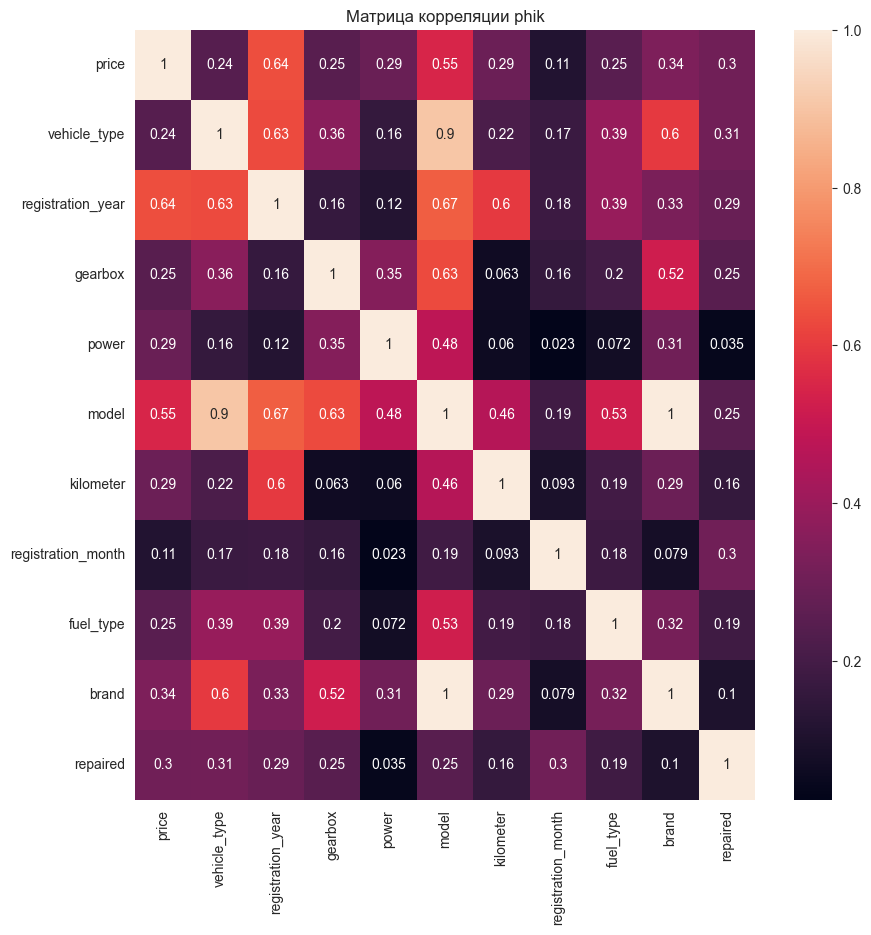

In [34]:
interval_cols = ['price', 'power']

corr_matrix = data.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='rocket')
plt.title('Матрица корреляции phik')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы о том, как различные признаки связаны с целевым признаком price:

Самая сильная корреляция с price:

model (0.550) — Модель автомобиля демонстрирует наибольшую корреляцию с ценой.

Умеренная корреляция:

* power (0.287) — Мощность двигателя также оказывает влияние на цену. Чем больше мощность, тем дороже автомобиль.
* gearbox (0.273) — Тип коробки передач связан с ценой. Автомобили с автоматической коробкой часто дороже, что, возможно, и отражено в корреляции.
* kilometer (0.278) — Пробег автомобиля имеет умеренную отрицательную корреляцию с ценой: чем больше пробег, тем ниже цена.
* brand (0.333) — Бренд автомобиля также оказывает влияние на цену, что логично: разные бренды занимают разные ниши на рынке.
* repaired (0.301) — Наличие/отсутствие ремонта связано с ценой, возможно, отремонтированные автомобили дешевле.

## Обучение моделей

Замена категориальных переменных на числовые

In [35]:
# Разделение данных на признаки и целевую переменную
X = data.drop('price', axis=1)
y = data['price']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение числовых и категориальных признаков
numerical_cols = ['registration_year', 'power', 'kilometer', 'registration_month']
categorical_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Предобработка для линейной модели (OneHotEncoder и масштабирование)
preprocessor_linear = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
])

In [36]:
# Предобработка для остальных моделей (OrdinalEncoder без масштабирования)
preprocessor_other = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
])

In [37]:
pipeline_linear = Pipeline(steps=[
    ('preprocessor', preprocessor_linear),
    ('model', LinearRegression())
]);

# Определяем метрику RMSE для оценки
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Время обучения для Linear Regression
start_time = time.time()
pipeline_linear.fit(X_train, y_train)
end_time = time.time()
training_time_lr = end_time - start_time

# Кросс-валидация с 5 фолдами для RMSE
cv_scores_lr = cross_val_score(pipeline_linear, X_train, y_train, cv=5, scoring=rmse_scorer)
rmse_lr = cv_scores_lr.mean()

# Время предсказания на тренировочной выборке
start_time = time.time()
y_pred_lr_train = pipeline_linear.predict(X_train)
end_time = time.time()
prediction_time_lr_train = end_time - start_time

print(f"RMSE на кросс-валидации для Linear Regression: {rmse_lr:.2f}")
print(f"Время обучения Linear Regression: {training_time_lr:.2f} секунд")
print(f"Время предсказания на тренировочной выборке для Linear Regression: {prediction_time_lr_train:.2f} секунд")


C:\Users\dinos\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dinos\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RMSE на кросс-валидации для Linear Regression: 2037.94
Время обучения Linear Regression: 2.80 секунд
Время предсказания на тренировочной выборке для Linear Regression: 0.27 секунд


In [38]:
pipeline_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor_other),
    ('model', CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        random_state=42,
        verbose=0
    ))
])

# Время обучения для CatBoost
start_time = time.time()
pipeline_catboost.fit(X_train, y_train)
end_time = time.time()
training_time_catboost = end_time - start_time

# Кросс-валидация для RMSE CatBoost
cv_scores_catboost = cross_val_score(pipeline_catboost, X_train, y_train, cv=5, scoring=rmse_scorer)
rmse_catboost = cv_scores_catboost.mean()

# Время предсказания на тренировочной выборке
start_time = time.time()
y_pred_catboost_train = pipeline_catboost.predict(X_train)
end_time = time.time()
prediction_time_catboost_train = end_time - start_time

print(f"RMSE на кросс-валидации для CatBoostRegressor: {rmse_catboost:.2f}")
print(f"Время обучения CatBoostRegressor: {training_time_catboost:.2f} секунд")
print(f"Время предсказания на тренировочной выборке для CatBoostRegressor: {prediction_time_catboost_train:.2f} секунд")


RMSE на кросс-валидации для CatBoostRegressor: 1309.96
Время обучения CatBoostRegressor: 8.86 секунд
Время предсказания на тренировочной выборке для CatBoostRegressor: 0.56 секунд


In [39]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_other),
    ('model', XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        subsample=1,
        colsample_bytree=1,
        random_state=42,
        verbosity=0,
        n_jobs=-1
    ))
])

# Время обучения для XGB
start_time = time.time()
pipeline_xgb.fit(X_train, y_train)
end_time = time.time()
training_time_xgb = end_time - start_time

# Кросс-валидация для RMSE XGB
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring=rmse_scorer)
rmse_xgb = cv_scores_xgb.mean()

# Время предсказания на тренировочной выборке
start_time = time.time()
y_pred_xgb_train = pipeline_xgb.predict(X_train)
end_time = time.time()
prediction_time_xgb_train = end_time - start_time

print(f"RMSE на кросс-валидации для XGBRegressor: {rmse_xgb:.2f}")
print(f"Время обучения XGBRegressor: {training_time_xgb:.2f} секунд")
print(f"Время предсказания на тренировочной выборке для XGBRegressor: {prediction_time_xgb_train:.2f} секунд")


RMSE на кросс-валидации для XGBRegressor: 1498.89
Время обучения XGBRegressor: 0.53 секунд
Время предсказания на тренировочной выборке для XGBRegressor: 0.27 секунд


In [40]:
# Параметры для GridSearch
param_grid = {
    'model__num_leaves': [50, 70],
    'model__learning_rate': [ 0.05, 0.1]
}

# Создаем пайплайн для LightGBM
pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor_other),  # предполагаю, что preprocessor_other определен ранее
    ('model', lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',
        metric='rmse',
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=42
    ))
])

# Используем GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=pipeline_lgb, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Время оптимизации гиперпараметров
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
optimization_time = end_time - start_time

# Лучшие параметры и результат
best_params = grid_search.best_params_
best_rmse = (-grid_search.best_score_)**0.5  # конвертируем обратно из отрицательного MSE в RMSE

# Время предсказания на тренировочной выборке
start_time = time.time()
y_pred_lgb_train = grid_search.predict(X_train)
end_time = time.time()
prediction_time_lgb_train = end_time - start_time

# Вычисление RMSE на тренировочной выборке
rmse_train = mean_squared_error(y_train, y_pred_lgb_train, squared=False)

# Вывод результатов
print(f"Лучшие параметры: {best_params}")
print(f"Лучший RMSE на кросс-валидации: {best_rmse:.2f}")
print(f"RMSE на тренировочной выборке с оптимизированной моделью: {rmse_train:.2f}")
print(f"Время предсказания на тренировочной выборке для LightGBM: {prediction_time_lgb_train:.2f} секунд")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

## Анализ моделей

In [41]:
# Сравнение моделей по RMSE на кросс-валидации
results_cv = pd.DataFrame({
    'Модель': ['Linear Regression', 'CatBoostRegressor', 'XGBRegressor', 'LightGBM'],
    'RMSE на кросс-валидации': [rmse_lr, rmse_catboost, rmse_xgb, best_rmse],
    'Время обучения (sec)': [training_time_lr, training_time_catboost, training_time_xgb  , optimization_time],
    'Время предсказания (sec)': [prediction_time_lr_train, 
                                 prediction_time_catboost_train, 
                                 prediction_time_xgb_train, 
                                 prediction_time_lgb_train]
})
results_cv

,Модель,RMSE на кросс-валидации,Время обучения (sec),Время предсказания (sec)
0,Linear Regression,2037.939517,2.804922,0.268358
1,CatBoostRegressor,1309.960284,8.864983,0.559504
2,XGBRegressor,1498.890101,0.526160,0.267262
3,LightGBM,1333.696603,16.929737,0.448137


In [42]:
best_model_name = results_cv.loc[results_cv['RMSE на кросс-валидации'].idxmin(), 'Модель']

# Оценка лучшей модели на тестовой выборке (для примера возьмем модель CatBoost)
if best_model_name == 'CatBoostRegressor':
    y_pred_test = pipeline_catboost.predict(X_test)
elif best_model_name == 'XGBRegressor':
    y_pred_test = pipeline_xgb.predict(X_test)
elif best_model_name == 'LightGBM':
    y_pred_test = pipeline_lgb.predict(X_test)
else:
    y_pred_test = pipeline_linear.predict(X_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Лучшая модель: {best_model_name}")
print(f"RMSE на тестовой выборке для лучшей модели: {rmse_test:.2f}")

Лучшая модель: CatBoostRegressor
RMSE на тестовой выборке для лучшей модели: 1304.24


### Вывод:

В разделе "Анализ моделей" были выполнены следующие задачи:

* Создана таблица для сравнения метрик моделей.
* На основе критериев заказчика выбрана наилучшая модель, и ее качество проверено на тестовой выборке.

Результаты выполнения задач этого раздела показали следующее:

Лучшая модель градиентного бустинга CatBoostRegressor на тестовой выборке имеет значение метрики RMSE = 1304.24 и скорость обучения в 31 секунду. Для всех моделей значение метрики RMSE не превышает 2500, что соответствует первоначальному требованию, указанному в задаче проекта.